In [1]:
!pip install pytorch_forecasting
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import holidays
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import lightning.pytorch as pl

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE
import random

random.seed(30)
np.random.seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

## Взгляним на основные распределения в данных

**В этом задании вам предстоит спрогнозировать годовой объем продаж четырёх товаров в двух конкурирующих торговых сетях, которые работают в шести разных странах.**

In [3]:
# Загрузка данных

train = pd.read_csv("/content/train.csv.zip")
train.drop('row_id', axis=1, inplace=True)
train['num_sold'] = train['num_sold'].astype(np.float32)

# Добавляем time_idx (id даты для модели)
time_idxs_map = {date: time_idx for time_idx, date in enumerate(sorted(train['date'].unique()))}
train['time_idx'] = train['date'].map(time_idxs_map)

train = train[train['date'] <= '2019-12-31']

train['date'] = pd.to_datetime(train['date'])

display(train.sample(4))

,date,country,store,product,num_sold,time_idx
41678,2019-05-19,France,KaggleRama,Kaggle Recipe Book,74.0,868
47706,2019-09-21,Spain,KaggleMart,Kaggle Recipe Book,161.0,993
3997,2017-03-25,France,KaggleRama,Kaggle Getting Started,80.0,83
37695,2019-02-25,France,KaggleRama,Kaggle for Kids: One Smart Goose,120.0,785


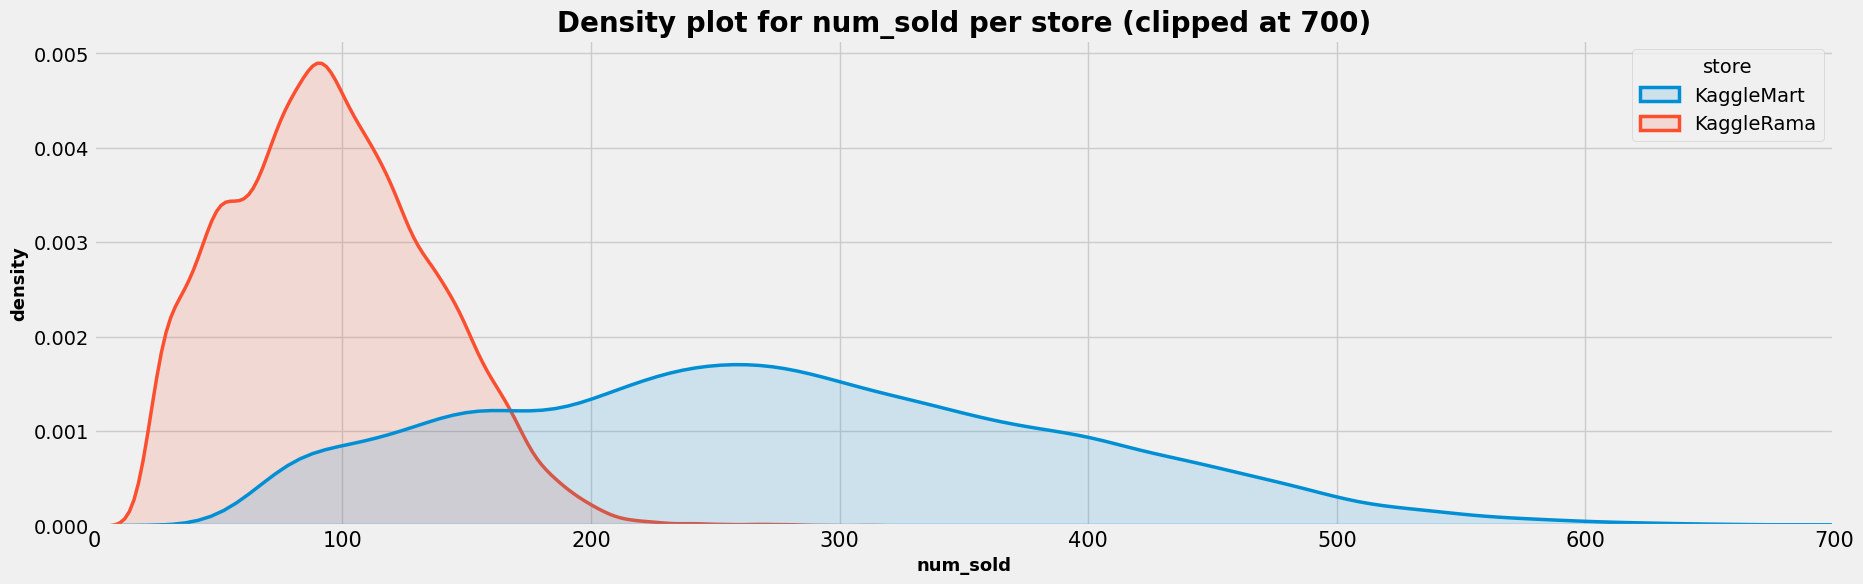

In [4]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))

sns.kdeplot(data=train, x = 'num_sold', hue = 'store', fill=True, alpha = 0.15, ax = ax, linewidth=2.5)
ax.set_xlabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(0, 700)
ax.set_title('Density plot for num_sold per store (clipped at 700)', fontweight = 'bold', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=15)

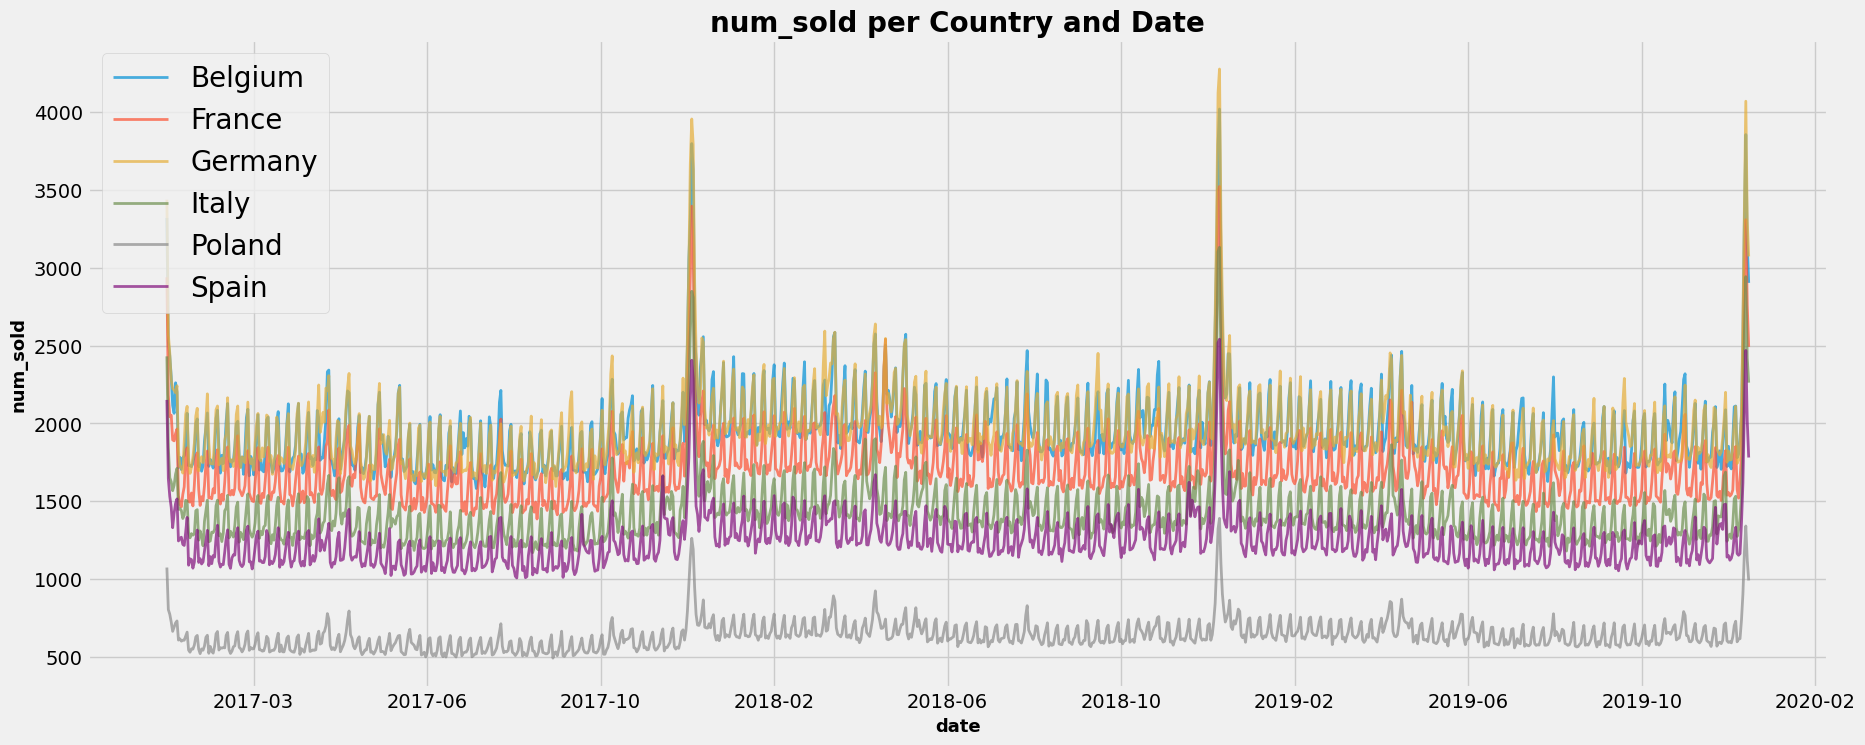

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='date',y='num_sold',hue='country',data=(train.groupby(['date', 'country']).num_sold.sum().rename('num_sold')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.legend(fontsize = 20, loc = 'upper left')
ax.set_title('num_sold per Country and Date', fontweight = 'bold', fontsize = 20);

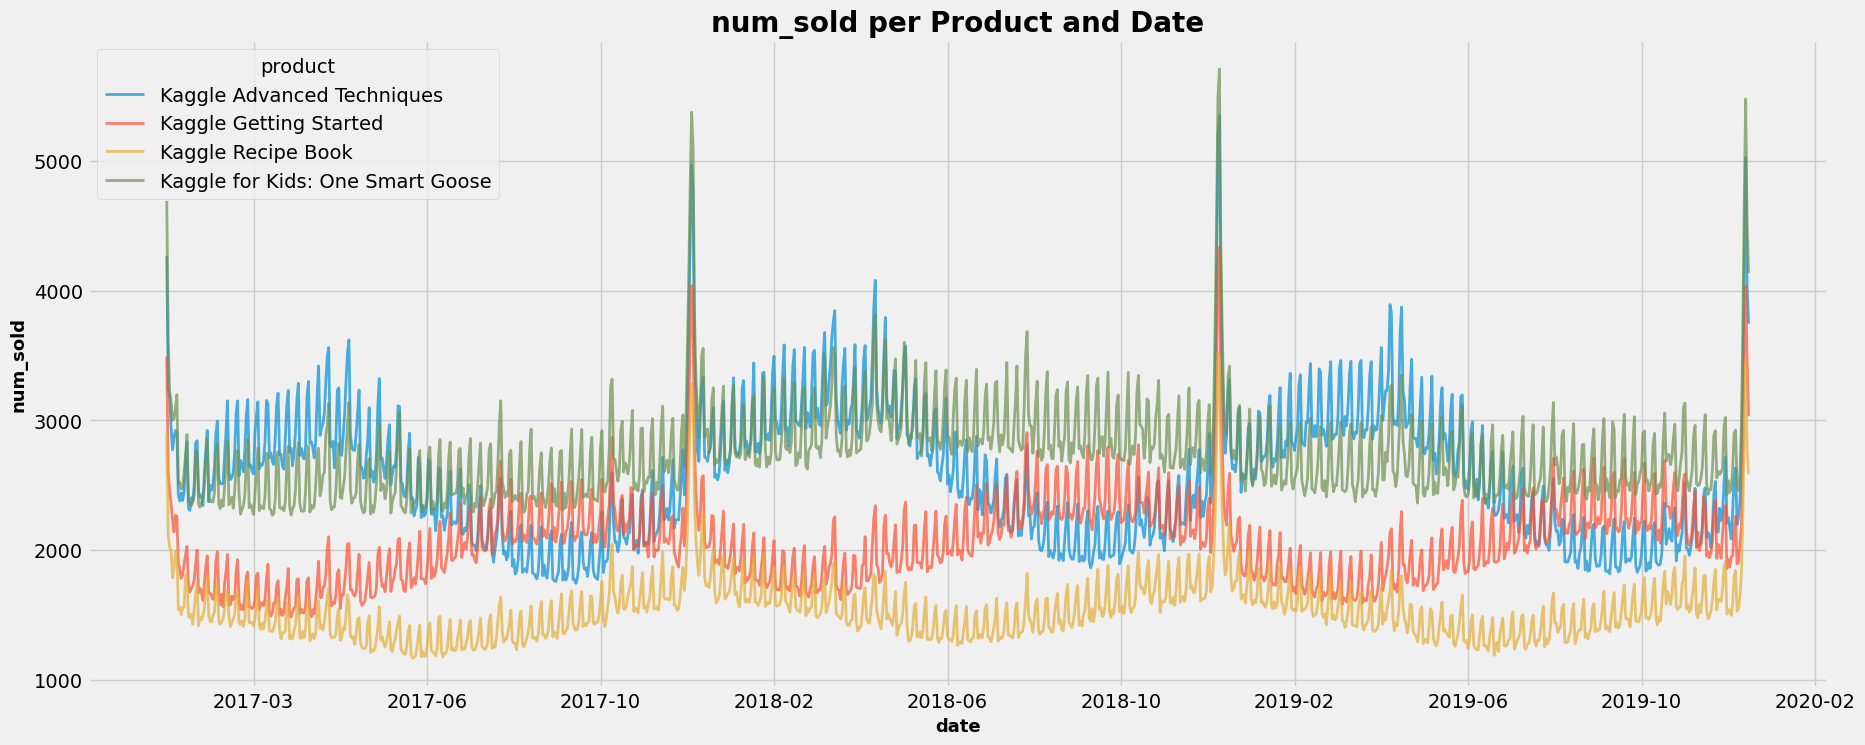

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
sns.lineplot(x='date',y='num_sold',hue='product',data=(train.groupby(['date', 'product']).num_sold.sum().rename('num_sold')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
ax.set_xlabel('date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('num_sold', color='black', fontweight='bold', fontsize=13)
ax.set_title('num_sold per Product and Date', fontweight = 'bold', fontsize = 20);

## Задание

Напишите функцию `add_date_features`, которая извлекает из дат (`date`) день недели (`day_of_week`) и месяц (`month`), сразу добавляя их в датафрем. Для работы модели категориальные признаки надо конвертировать в строку (`str`) или категорию (`"category"`).

In [7]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts weekday and month from dates and adds them to DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'date' column

    Returns:
        pd.DataFrame: Original DataFrame with added weekday and month columns
                     as string or category type
    """
    df['day_of_week'] = df['date'].dt.day_name().astype('category')  # Get weekday name
    df['month'] = df['date'].dt.month_name().astype('category')  # Get month name
    return df

Напишите функцию `get_holiday_features`, которая проверяет даты (`date`) на праздничный день в стране (`country`) с учётом сдвига (`shift`) и возвращает `pd.Series` булевых флагов `True/False`. Пригодится библиотека `holidays`. Для работы модели категориальные признаки надо конвертировать в строку (`str`) или категорию (`"category"`).

In [8]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import timedelta

In [ ]:
train['country'].value_counts()

,count
country,
Belgium,8760
France,8760
Germany,8760
Italy,8760
Poland,8760
Spain,8760


In [35]:
import holidays
def get_holiday_features(df: pd.DataFrame, shift: int = 0) -> pd.Series:
    countries = df["country"].astype(str)
    country_map = {
        "Belgium": holidays.BE(),
        "France": holidays.FR(),
        "Germany": holidays.DE(),
        "Italy": holidays.IT(),
        "Poland": holidays.PL(),
        "Spain": holidays.ES(),
    }
    shifted_dates = pd.to_datetime(df["date"]) + pd.Timedelta(days=shift)
    res = []
    for dt, c in zip(shifted_dates, countries):
        if c in country_map:
            res.append(dt in country_map[c])
        else:
            res.append(False)
    # Вернуть булевы значения с типом category
    return pd.Series(res, index=df.index).astype("category")

## Обогатим данные новыми признаками

In [36]:
train = add_date_features(train)
for name, shift in zip(['is_holiday', 'is_holiday_lead_1', 'is_holiday_lead_2'], [0, 1, 2]):
    print(f'Starting "{name}"...')
    train[name] = get_holiday_features(train, shift)
    print(f'Done "{name}"')

Starting "is_holiday"...
Done "is_holiday"
Starting "is_holiday_lead_1"...
Done "is_holiday_lead_1"
Starting "is_holiday_lead_2"...
Done "is_holiday_lead_2"


In [37]:
# Убедимся, что новые признаки не относятся к типу int или bool
train.dtypes

,0
date,datetime64[ns]
country,object
store,object
product,object
num_sold,float32
time_idx,int64
day_of_week,category
month,category
is_holiday,category
is_holiday_lead_1,category


## Тренировка модели

In [13]:
# Создадим датасет
max_prediction_length = 365
max_encoder_length = train['date'].nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    train[train['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"],
    min_encoder_length=max_prediction_length,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    time_varying_known_categoricals=["month", "day_of_week", "is_holiday",
                                     "is_holiday_lead_1", "is_holiday_lead_2"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["num_sold"],
    target_normalizer=GroupNormalizer(
        groups=["country", "store", "product"], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [14]:
# Создаем валидационный датасет (predict=True)

validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# Даталоадеры для модели
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size *10 )

In [15]:
# Построим baseline для сравнения

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)

mae = MAE()
print(f"Baseline MAE: {mae(actuals.to(DEVICE), baseline_predictions.to(DEVICE))}")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Baseline MAE: 116.47122955322266


In [16]:
PATIENCE = 30
MAX_EPOCHS = 100
LEARNING_RATE = 0.03
OPTUNA = False

In [17]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.25,
    limit_train_batches=10,
    callbacks=[lr_logger, early_stop_callback]
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=SMAPE(),
    log_interval=10,  # for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 24.8k


In [18]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 151    | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.5 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

predictions = best_tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"))

mae = MAE()
print(f"Predicted MAE: {mae(actuals.to(DEVICE), predictions.to(DEVICE))}")

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicted MAE: 21.984806060791016


## Посмотрим на интерпретируемость модели

In [ ]:
%%capture
val_prediction_results = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
)

interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
interpretation_plots = best_tft.plot_interpretation(interpretation)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [20]:
%%capture
val_prediction_results = best_tft.predict(
    val_dataloader,
    mode="raw",
    return_x=True,
)

interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
interpretation_plots = best_tft.plot_interpretation(interpretation)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


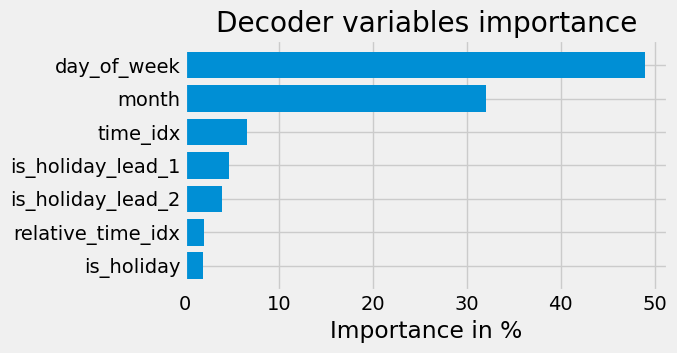

In [21]:
interpretation_plots['decoder_variables']

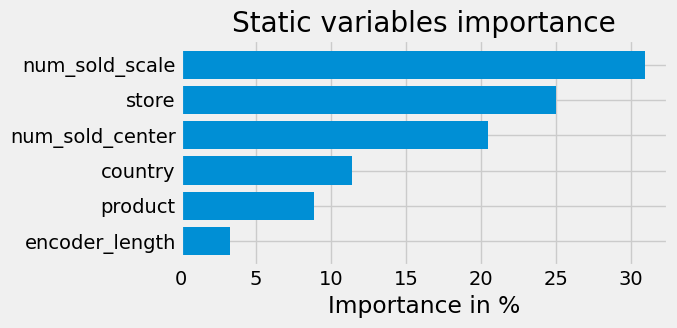

In [22]:
interpretation_plots['static_variables']